In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Normalization: from [0, 1] to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Sample batch
images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 32.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.91MB/s]


Images shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128])


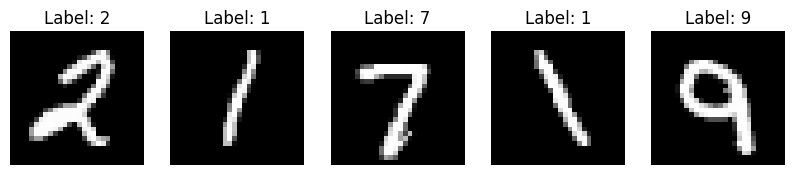

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Hyperparameters
latent_dim = 20
hidden_dim = 400
image_dim = 28 * 28
num_classes = 10

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.fc1 = nn.Linear(image_dim + num_classes, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar

        self.fc3 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_dim)

    def encode(self, x, y):
        # Concatenate image and label
        inputs = torch.cat([x, y], dim=1)
        h1 = F.relu(self.fc1(inputs))
        return self.fc21(h1), self.fc22(h1)  # mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        inputs = torch.cat([z, y], dim=1)
        h3 = F.relu(self.fc3(inputs))
        return self.fc4(h3)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar


In [5]:
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()

# Example:
images = images.view(-1, 28*28)  # flatten images
labels_onehot = one_hot(labels)


In [8]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10  # you can increase if needed

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, 28*28).to(device)  # Flatten images
        labels = labels.to(device)
        one_hot_labels = one_hot(labels).to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, one_hot_labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch [1/10], Loss: 71827727634450.9688
Epoch [2/10], Loss: 925599117248045.6250
Epoch [3/10], Loss: 2106077683923680382418944.0000
Epoch [4/10], Loss: 2826458390266357470986240.0000
Epoch [5/10], Loss: 2826458258756444752969728.0000
Epoch [6/10], Loss: 2826457728873721032081408.0000
Epoch [7/10], Loss: 2826456937585261924057088.0000
Epoch [8/10], Loss: 2826456726370041911574528.0000
Epoch [9/10], Loss: 2826456381185343545671680.0000
Epoch [10/10], Loss: 2826455550966568037908480.0000


In [11]:
model_path = "cvae_mnist.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Model saved to: cvae_mnist.pth
